# Training ESRGAN

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, SpectralNormalization
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input  # Import the Input class
from tensorflow.keras.optimizers import Adam  #Import the Adam optimizer
from tensorflow.keras.models import Model  #Import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import typing
from keras.callbacks import TensorBoard

In [6]:
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.applications import VGG19

## Define ESRGAN

### RRDB

In [2]:
class ResidualDenseBlock(tf.keras.Model):
  def __init__(self, **kwargs):
    super(ResidualDenseBlock, self).__init__(**kwargs)
    self.conv_1 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_2 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_3 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_4 = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME")
    self.conv_5 = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="SAME")

    self.activation_1 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.activation_2 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.activation_3 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.activation_4 = tf.keras.layers.LeakyReLU(alpha=0.2)

  def call(self, x):
    x1 = self.activation_1(self.conv_1(x))
    x2 = self.activation_2(self.conv_2(layers.concatenate([x, x1])))
    x3 = self.activation_3(self.conv_3(layers.concatenate([x, x1, x2])))
    x4 = self.activation_4(self.conv_4(layers.concatenate([x, x1, x2, x3])))
    x5 = self.conv_5(layers.concatenate([x, x1, x2, x3, x4]))

    # Emperically, we use 0.2 to scale the residual for better performance
    return x5 * 0.2 + x

class RRDB(tf.keras.Model):
  def __init__(self, **kwargs):
    super(RRDB, self).__init__(**kwargs)
    self.res_1 = ResidualDenseBlock()
    self.res_2 = ResidualDenseBlock()
    self.res_3 = ResidualDenseBlock()

  def call(self, x_input):
    x = self.res_1(x_input)
    x = self.res_2(x)
    x = self.res_3(x)

    return x * 0.2 + x_input

### RRDBNet

In [3]:
class RRDBNet(tf.keras.Model):
  def __init__(self, **kwargs):
    super(RRDBNet, self).__init__(**kwargs)
    self.first_conv = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.rb_1 = RRDB()
    self.rb_2 = RRDB()
    self.rb_3 = RRDB()
    self.rb_4 = RRDB()
    self.rb_5 = RRDB()
    self.rb_6 = RRDB()
    self.conv_body = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1

    self.up_1 = layers.UpSampling2D()
    self.conv_1 = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.activation_1 = tf.keras.layers.LeakyReLU(alpha=0.2)

    self.up_2 = layers.UpSampling2D()
    self.conv_2 = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.activation_2 = tf.keras.layers.LeakyReLU(alpha=0.2)

    self.conv_3 = layers.Conv2D(64, 3, strides=(1, 1), padding="SAME") # padding 1
    self.activation_3 = tf.keras.layers.LeakyReLU(alpha=0.2)
    self.conv_4 = layers.Conv2D(3, 3, strides=(1, 1), padding="SAME") # padding 1

  def call(self, x_input):
    x = self.first_conv(x_input)
    x1 = self.rb_1(x)
    x1 = self.rb_2(x1)
    x1 = self.rb_3(x1)
    x1 = self.rb_4(x1)
    x1 = self.rb_5(x1)
    x1 = self.rb_6(x1)
    x1 = self.conv_body(x1)

    x = x + x1

    x = self.up_1(x)
    x = self.conv_1(x)
    x = self.activation_1(x)

    x = self.up_2(x)
    x = self.conv_2(x)
    x = self.activation_2(x)

    x = self.conv_3(x)
    x = self.activation_3(x)
    x = self.conv_4(x)

    return x

### Discriminator

In [4]:
class UNetDiscriminator(tf.keras.Model):
  def __init__(self, **kwargs):
    super(UNetDiscriminator, self).__init__(**kwargs)

    self.conv_0 = SpectralNormalization(layers.Conv2D(64, 3, strides=(1, 1), padding="SAME", use_bias=False))
    self.conv_1 = SpectralNormalization(layers.Conv2D(128, 4, strides=(2, 2), padding="SAME", use_bias=False))
    self.conv_2 = SpectralNormalization(layers.Conv2D(256, 4, strides=(2, 2), padding="SAME", use_bias=False))
    self.conv_3 = SpectralNormalization(layers.Conv2D(512, 4, strides=(2, 2), padding="SAME", use_bias=False))

    self.conv_4 = SpectralNormalization(layers.Conv2D(256, 3, strides=(1, 1), padding="SAME", use_bias=False))
    self.conv_5 = SpectralNormalization(layers.Conv2D(128, 3, strides=(1, 1), padding="SAME", use_bias=False))
    self.conv_6 = SpectralNormalization(layers.Conv2D(64, 3, strides=(1, 1), padding="SAME", use_bias=False))

    self.conv_7 = SpectralNormalization(layers.Conv2D(64, 3, strides=(1, 1), padding="SAME", use_bias=False))
    self.conv_8 = SpectralNormalization(layers.Conv2D(64, 3, strides=(1, 1), padding="SAME", use_bias=False))

    self.conv_9 = SpectralNormalization(layers.Conv2D(1, 3, strides=(1, 1), padding="SAME", use_bias=False))
    # Add a Global Average Pooling layer to reduce the output to a single value
    self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()

  def call(self, x):
    x0 = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_0(x)) # 256x256
    x1 = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_1(x0)) # 128x128
    x2 = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_2(x1))  # 64x64
    x3 = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_3(x2)) # 32x32

    x3 = tf.keras.layers.UpSampling2D(interpolation="bilinear")(x3)
    x4 = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_4(x3)) # 64x64

    x4 = x4 + x2

    x4 = tf.keras.layers.UpSampling2D(interpolation="bilinear")(x4)
    x5 = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_5(x4)) # 128x128

    x5 = x5 + x1

    x5 = tf.keras.layers.UpSampling2D(interpolation="bilinear")(x5)
    x6 = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_6(x5)) # 256x256

    x6 = x6 + x0

    out = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_7(x6)) # 256x256
    out = tf.keras.layers.LeakyReLU(alpha=0.2)(self.conv_8(out)) # 256x256
    out = self.conv_9(out)

    out = self.global_avg_pooling(out)

    return out

In [5]:
# class GAN(tf.keras.models.Model):
#     """A Generative Adversarial Network (GAN) implementation.

#     This class inherits from `tf.keras.models.Model` and provides a
#     straightforward implementation of the GAN algorithm.
#     """
#     def __init__(
#             self,
#             discriminator: tf.keras.models.Model,
#             generator: tf.keras.models.Model,
#             noise_dim: int,
#             **kwargs
#         ) -> None:
#         """Initializes the GAN class.

#         Args:
#             discriminator (tf.keras.models.Model): A `tf.keras.model.Model` instance that acts
#                 as the discriminator in the GAN algorithm.
#             generator (tf.keras.models.Model): A `tf.keras.model.Model` instance that acts as
#                 the generator in the GAN algorithm.
#             noise_dim (int): The dimensionality of the noise vector that is
#                 inputted to the generator.
#         """
#         super(GAN, self).__init__(**kwargs)
#         self.discriminator = discriminator
#         self.generator = generator
#         self.noise_dim = noise_dim

#     # def compile(self, discriminator_opt, generator_opt, discriminator_loss, generator_loss, **kwargs):
#     #     """Configures the model for training."""
#     #     super(GAN, self).compile(**kwargs)  # No extra arguments needed here
#     #     self.discriminator_opt = discriminator_opt  # Store optimizers as attributes
#     #     self.generator_opt = generator_opt
#     #     self.discriminator_loss = discriminator_loss  # Store losses as attributes
#     #     self.generator_loss = generator_loss

    # def train_step(self, data: tf.Tensor) -> typing.Dict[str, tf.Tensor]:
    #     """Executes one training step and returns the loss.

    #     Args:
    #         data (tf.Tensor): A batch of real images from the dataset.

    #     Returns:
    #         typing.Dict[str, tf.Tensor]: A dictionary of metric values and losses.
    #     """
    #     lr_images, hr_images = data  # Assuming your dataset yields (lr_images, hr_images) tuples

    #     batch_size = tf.shape(lr_images)[0]
    #     # Generate random noise for the generator
    #     noise = tf.random.normal([batch_size, self.noise_dim])

    #     # Train the discriminator with both real images (label as 1) and fake images (label as 0)
    #     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #         # Generate fake images using the generator
    #         generated_images = self.generator(lr_images, training=True)

    #         # Get the discriminator's predictions for real and fake images
    #         real_output = self.discriminator(hr_images, training=True)
    #         fake_output = self.discriminator(generated_images, training=True)

    #         # Calculate generator and discriminator losses
    #         disc_loss = self.loss['discriminator'](real_output, fake_output)  # Using self.loss[0] for discriminator loss
    #         gen_loss = self.loss['generator'](hr_images, generated_images, fake_output)  # Using self.loss[1] for generator loss

    #         # gen_loss = self.generator_loss(hr_images, generated_images, fake_output)
    #         # disc_loss = self.discriminator_loss(real_output, fake_output)

    #         # # Calculate generator and discriminator losses using the specified loss functions
    #         # gen_loss = self.compiled_loss.fn(
    #         #     y_true=[hr_images, tf.ones_like(fake_output)],  # Targets for generator
    #         #     y_pred=[generated_images, fake_output],  # Predictions from generator
    #         # )
    #         # disc_loss = self.compiled_loss.fn(
    #         #     y_true=[tf.ones_like(real_output), tf.zeros_like(fake_output)],  # Targets for discriminator
    #         #     y_pred=[real_output, fake_output],  # Predictions from discriminator
    #         # )

    #     # Calculate gradients of generator and discriminator
    #     gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    #     gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

    #     # Apply gradients to generator and discriminator optimizer
    #     self.optimizer['generator'].apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables)) # apply to generator optimizer
    #     self.optimizer['discriminator'].apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables)) # apply to discriminator optimizer

    #     psnr = psnr_metric(hr_images, generated_images)
    #     ssim = ssim_metric(hr_images, generated_images)

    #     # Update the metrics.
    #     self.compiled_metrics.update_state(real_output, fake_output)

    #     # Construct a dictionary of metric results and losses
    #     results = {m.name: m.result() for m in self.metrics}
    #     results.update({"d_loss": disc_loss, "g_loss": gen_loss, "psnr_metric": psnr, "ssim_metric": ssim})

#         return results
#     def call(self, inputs, training=None, mask=None):
#         """Defines the forward pass of the GAN model.

#         Args:
#             inputs: The input tensor.
#             training: Boolean indicating whether the model is in training mode.
#             mask: Optional mask tensor.

#         Returns:
#             The output of the generator.
#         """
#         # In this case, we're simply returning the output of the generator
#         return self.generator(inputs, training=training)

### Define constants

In [1]:
BATCH_SIZE = 4
LR_SIZE = (96, 96)  # Low resolution size
HR_SIZE = (384, 384)  # High resolution size
EPOCHS = 10

### Define VGG Feature Extractor

In [ ]:
class VGGFeatureExtractor:
    vgg = VGG19(weights='imagenet', include_top=False)
    model = Model(inputs=vgg.input,
                          outputs=vgg.get_layer('block5_conv4').output)
    model.trainable = False

    def __init__(self):
        pass

    def normalize_vgg(self, img):
        # Convert from [-1, 1] to [0, 255]
        img = (img + 1) * 127.5
        return tf.keras.applications.vgg19.preprocess_input(img)

    def get_features(self, img):
        img = self.normalize_vgg(img)
        return self.model(img)

In [ ]:
# class ValidationMetricsCallback(tf.keras.callbacks.Callback):
#        def __init__(self, valid_dataset):
#            super(ValidationMetricsCallback, self).__init__()
#            self.valid_dataset = valid_dataset

#        def on_epoch_end(self, epoch, logs=None):
#            psnr_values = []
#            ssim_values = []
#            for lr_images, hr_images in self.valid_dataset:
#                sr_images = self.model.generator(lr_images, training=False)
#                psnr_values.append(psnr_metric(hr_images, sr_images).numpy())
#                ssim_values.append(ssim_metric(hr_images, sr_images).numpy())

#            avg_psnr = np.mean(psnr_values)
#            avg_ssim = np.mean(ssim_values)
#            print(f"Epoch {epoch + 1}: Validation PSNR: {avg_psnr:.4f}, Validation SSIM: {avg_ssim:.4f}")

#            val_loss = self.model.evaluate(self.valid_dataset, verbose=0)[0]  # Get loss from evaluate()

#            print(f"Epoch {epoch + 1}: Validation Loss: {val_loss:.4f}")

#            # Store metrics in logs if needed
#            logs = logs or {}
#            logs['val_loss'] = val_loss
#            logs['val_psnr'] = avg_psnr
#            logs['val_ssim'] = avg_ssim

### Define Losses

In [ ]:
class SRGANLosses:
    def __init__(self):
        self.vgg = VGGFeatureExtractor()
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    def perceptual_loss(self, hr_img, sr_img):
        hr_features = self.vgg.get_features(hr_img)
        sr_features = self.vgg.get_features(sr_img)
        return self.mse_loss(hr_features, sr_features)

    def content_loss(self, hr_img, sr_img):
        return self.mse_loss(hr_img, sr_img)

In [ ]:
def relativistic_discriminator_loss(real_output, fake_output):
    """
    Calculates the relativistic discriminator loss.

    Args:
        real_output: Discriminator output for real images.
        fake_output: Discriminator output for fake images.

    Returns:
        The relativistic discriminator loss.
    """
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output)
    )
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(
        tf.zeros_like(fake_output), fake_output - tf.reduce_mean(real_output)
    )
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def total_generator_loss(hr_img, sr_img, fake_output, lambda_adv=5e-3, eta_l1=1e-2):
    """
    Calculates the total loss for the generator.

    Args:
        hr_img: The high-resolution image tensor.
        sr_img: The super-resolution image tensor.
        fake_output: Discriminator output for fake images.
        lambda_adv: Weight for the adversarial loss.
        eta_l1: Weight for the L1 loss.

    Returns:
        The total loss for the generator.
    """
    losses = SRGANLosses()  # Assuming you have your SRGANLosses class defined

    # Perceptual Loss (content loss)
    perceptual_loss = losses.perceptual_loss(hr_img, sr_img)

    # Adversarial Loss
    adversarial_loss = generator_loss(fake_output)

    # L1 Loss
    l1_loss = tf.reduce_mean(tf.abs(hr_img - sr_img))

    # Total Loss
    total_loss = perceptual_loss + lambda_adv * adversarial_loss + eta_l1 * l1_loss

    return total_loss

### Preprocessing

In [ ]:
def preprocess_image(lr_img, hr_img):
    # Normalize to [-1, 1]
    lr_img = tf.cast(lr_img, tf.float32) / 127.5 - 1
    hr_img = tf.cast(hr_img, tf.float32) / 127.5 - 1

    # Resize if needed
    lr_img = tf.image.resize(lr_img, LR_SIZE)
    hr_img = tf.image.resize(hr_img, HR_SIZE)

    return lr_img, hr_img

### Load data

In [ ]:
def load_div2k():
    dataset, info = tfds.load('div2k/bicubic_x4', with_info=True, as_supervised=True)
    train_dataset = dataset['train']
    valid_dataset = dataset['validation']
    return train_dataset, valid_dataset

def load_and_preprocess_div2k(lr_size=LR_SIZE, hr_size=HR_SIZE, batch_size=BATCH_SIZE):
    # ... (Your existing load_div2k and preprocess_image functions) ...

    train_dataset, valid_dataset = load_div2k()

    train_dataset = (train_dataset
                     .map(preprocess_image)
                     .shuffle(1000)
                     .batch(batch_size)
                     .prefetch(tf.data.AUTOTUNE))

    valid_dataset = (valid_dataset
                     .map(preprocess_image)
                     .batch(batch_size)
                     .prefetch(tf.data.AUTOTUNE))
    return train_dataset, valid_dataset

In [ ]:
train_dataset, valid_dataset = load_and_preprocess_div2k(LR_SIZE, HR_SIZE, BATCH_SIZE)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.0EE0OK_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.0EE0OK_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


### Define metrics

In [ ]:
def psnr_metric(hr_img, sr_img):
    return tf.image.psnr(
        (hr_img + 1) * 127.5,
        (sr_img + 1) * 127.5,
        max_val=255
    )

def ssim_metric(hr_img, sr_img):
    return tf.image.ssim(
        (hr_img + 1) * 127.5,
        (sr_img + 1) * 127.5,
        max_val=255
    )

### Get models

In [ ]:
generator = RRDBNet()
discriminator = UNetDiscriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
generator_optimizer = Adam(learning_rate=2e-4, beta_1=0.9, beta_2=0.99)
discriminator_optimizer = Adam(learning_rate=1e-4)

### Define training

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(lr_images, hr_images):

    batch_size = tf.shape(lr_images)[0]

    # Train the discriminator with both real images (label as 1) and fake images (label as 0)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images using the generator
        generated_images = generator(lr_images, training=True)

        # Get the discriminator's predictions for real and fake images
        real_output = discriminator(hr_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate generator and discriminator losses
        disc_loss = relativistic_discriminator_loss(real_output, fake_output)  # Using self.loss[0] for discriminator loss
        gen_loss = total_generator_loss(hr_images, generated_images, fake_output)  # Using self.loss[1] for generator loss

    # Calculate gradients of generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to generator and discriminator optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # apply to generator optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # apply to discriminator optimizer

    # Calculate and track training metrics (PSNR and SSIM)
    psnr = psnr_metric(hr_images, generated_images)
    ssim = ssim_metric(hr_images, generated_images)

    # Return losses and metrics
    return disc_loss, gen_loss, psnr, ssim

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train_esrgan(epochs=EPOCHS, lr_size=LR_SIZE, hr_size=HR_SIZE, batch_size=BATCH_SIZE):

    history = {
        'g_loss': [],
        'val_g_loss': [],
        'd_loss': [],
        'val_d_loss': [],
        'psnr': [],
        'val_psnr': [],
        'ssim': [],
        'val_ssim': []
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        epoch_g_losses = []  # List to store generator losses for the current epoch
        epoch_d_losses = []  # List to store discriminator losses for the current epoch
        epoch_psnrs = []  # List to store PSNR values for the current epoch
        epoch_ssims = []  # List to store SSIM values for the current epoch

        for batch_i, (lr_images, hr_images) in enumerate(train_dataset):
            disc_loss, gen_loss, psnr, ssim = train_step(lr_images, hr_images)
            epoch_g_losses.append(gen_loss.numpy())
            epoch_d_losses.append(disc_loss.numpy())
            epoch_psnrs.append(psnr.numpy())
            epoch_ssims.append(ssim.numpy())

            print(f"Batch {batch_i+1}/{len(train_dataset)}", end='\r')

        history['g_loss'].append(np.mean(epoch_g_losses))
        history['d_loss'].append(np.mean(epoch_d_losses))
        history['psnr'].append(np.mean(epoch_psnrs))
        history['ssim'].append(np.mean(epoch_ssims))

        # Validation phase
        epoch_val_g_losses = []  # Store validation generator losses for the epoch
        epoch_val_d_losses = []  # Store validation discriminator losses for the epoch
        epoch_val_psnrs = []  # Store validation PSNR values for the epoch
        epoch_val_ssims = []  # Store validation SSIM values for the epoch

        for lr_images, hr_images in valid_dataset:
            sr_images = generator(lr_images, training=False)
            real_output = discriminator(hr_images, training=False)
            fake_output = discriminator(sr_images, training=False)
            g_loss = total_generator_loss(hr_images, sr_images, fake_output)
            d_loss = relativistic_discriminator_loss(real_output, fake_output)
            psnr = psnr_metric(hr_images, sr_images)
            ssim = ssim_metric(hr_images, sr_images)

            mean_psnr = tf.reduce_mean(psnr).numpy()  # Convert to NumPy scalar
            mean_ssim = tf.reduce_mean(ssim).numpy()  # Convert to NumPy scalar

            epoch_val_g_losses.append(g_loss.numpy())
            epoch_val_d_losses.append(d_loss.numpy())
            epoch_val_psnrs.append(mean_psnr)  # Assuming mean_psnr is already calculated
            epoch_val_ssims.append(mean_ssim)  # Assuming mean_ssim is already calculated

            history['val_g_loss'].append(np.mean(epoch_val_g_losses))
            history['val_d_loss'].append(np.mean(epoch_val_d_losses))
            history['val_psnr'].append(np.mean(epoch_val_psnrs))
            history['val_ssim'].append(np.mean(epoch_val_ssims))
            
            if mean_psnr > max(history['val_psnr']):
                checkpoint.save(file_prefix=checkpoint_prefix)
                generator.save('generator.h5')
                discriminator.save('discriminator.h5')
                print(f"Saved checkpoint and models at epoch {epoch+1}")

    return history


## Train ESRGAN

In [ ]:
history = train_esrgan()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [ ]:
history

In [ ]:
import numpy as np

def split_list(input_list, num_sublists=10):
    """
    Splits a list into a specified number of sublists with approximately equal length.

    Args:
        input_list: The list to be split.
        num_sublists: The desired number of sublists.

    Returns:
        A list of sublists.
    """

    sublist_length = len(input_list) // num_sublists  # Calculate sublist length

    # Use list comprehension and slicing to create sublists
    sublists = [input_list[i:i + sublist_length] for i in range(0, len(input_list), sublist_length)]

    # Handle any remaining elements (if the list length isn't perfectly divisible)
    if len(sublists) > num_sublists:
        sublists[-2] = sublists[-2] + sublists[-1]  # Merge the last two
        sublists = sublists[:-1]

    return sublists

def calculate_means(list_of_sublists):
    """
    Calculates the mean of each sublist in a list of sublists.

    Args:
        list_of_sublists: A list containing sublists.

    Returns:
        A list of the means of each sublist.
    """
    means = []
    for sublist in list_of_sublists:
        mean = np.mean(sublist)  # Calculate the mean of the sublist
        means.append(mean)  # Add the mean to the list of means
    return means

# # Example usage
# my_list = list(range(100))  # Create a sample list
# sublists = split_list(my_list, num_sublists=25)  # Split the list
# means_of_sublists = calculate_means(sublists)  # Calculate the means

# #To see the output, run the code.
# means_of_sublists

In [ ]:
history_got_scraped = len(history['g_loss']) == len(history['val_g_loss'])

g_loss_train = history['g_loss']
d_loss_train = history['d_loss']
psnr_train = history['psnr']
ssim_train = history['ssim']

if history_got_scraped:
    g_loss_val = calculate_means(split_list(history['val_g_loss']))
    d_loss_val = calculate_means(split_list(history['val_d_loss']))
    psnr_val = calculate_means(split_list(history['val_psnr']))
    ssim_val = calculate_means(split_list(history['val_ssim']))
else:
    g_loss_val = history['val_g_loss']
    val_d_loss = history['val_d_loss']
    val_psnr = history['val_psnr']
    val_ssim = history['val_ssim']

### Manually save models

In [49]:
generator.save('generator.keras') # or generator.save('generator.h5')
discriminator.save('discriminator.keras') # or discriminator.save('discriminator.h5')

## Result

In [35]:
import matplotlib.pyplot as plt

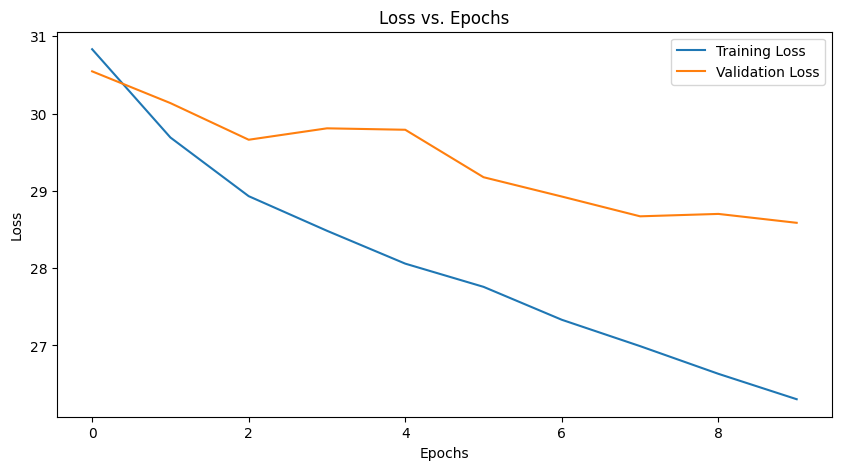

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(g_loss_train, label='Training Loss')
plt.plot(g_loss_val, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

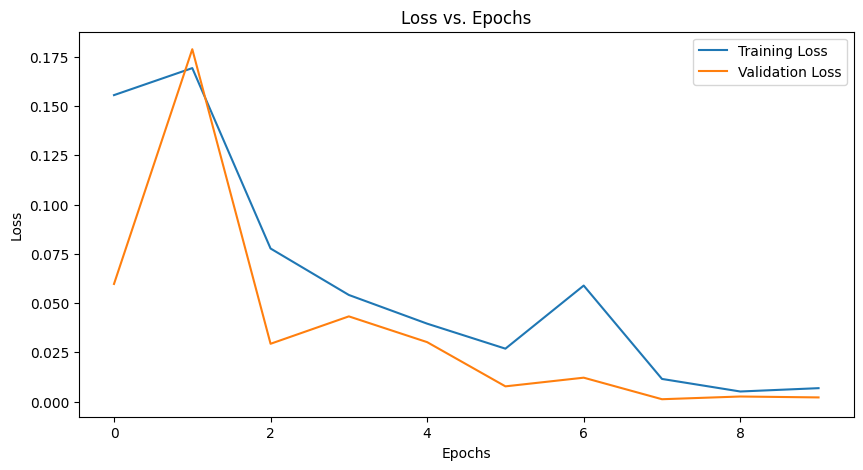

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(d_loss_train, label='Training Loss')
plt.plot(d_loss_val, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

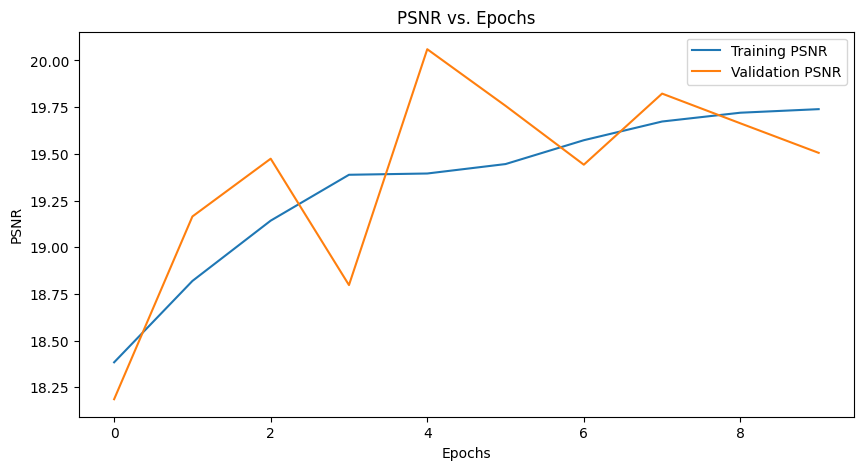

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(psnr_train, label='Training PSNR')
plt.plot(psnr_val, label='Validation PSNR')
plt.title('PSNR vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

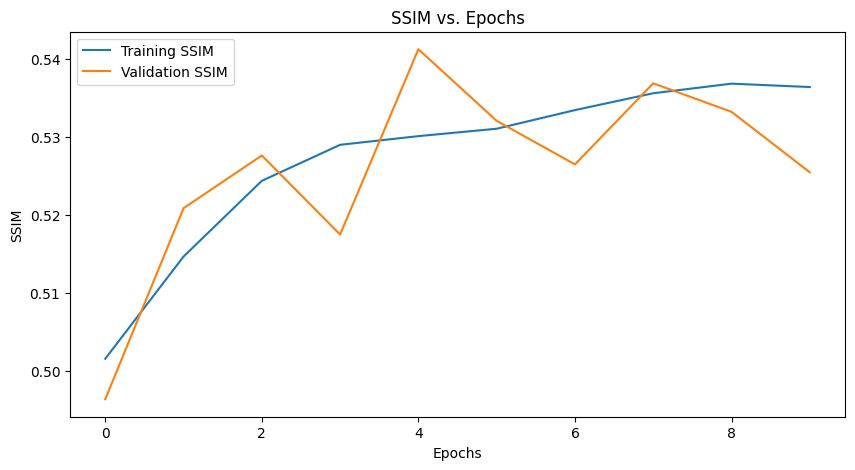

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(ssim_train, label='Training SSIM')
plt.plot(ssim_val, label='Validation SSIM')
plt.title('SSIM vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

In [43]:
min(g_loss_train), min(g_loss_val), min(d_loss_train), min(d_loss_val), max(psnr_train), max(psnr_val), max(ssim_train), max(ssim_val)

(26.304672,
 28.587242,
 0.005090252,
 0.0011674552,
 19.73911,
 20.0599,
 0.53687125,
 0.5412838)

In [ ]:
g_loss_train.index(min(g_loss_train)), 
g_loss_val.index(min(g_loss_val)), 
d_loss_train.index(min(d_loss_train)), 
d_loss_val.index(min(d_loss_val)), 
psnr_train.index(max(psnr_train)), 
psnr_val.index(max(psnr_val)), 
ssim_train.index(max(ssim_train)), 
ssim_val.index(max(ssim_val))

(9, 9, 8, 7, 9, 4, 8, 4)

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import custom_object_scope

# # Assuming your custom objects are RRDBNet, RRDB, and ResidualDenseBlock
# with custom_object_scope({'RRDBNet': RRDBNet, 'RRDB': RRDB, 'ResidualDenseBlock': ResidualDenseBlock, 'UNetDiscriminator': UNetDiscriminator}):
#     loaded_generator = load_model('generator.keras')
#     loaded_discriminator = load_model('discriminator.keras')